In [1]:
import numpy as np
from scipy.optimize import fsolve

# %matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
# print(plt.style.available)  # show available template
plt.style.use(['seaborn-ticks','seaborn-paper'])  # use a templet

import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['lines.color'] = 'r'
params = {
    'figure.figsize': [8, 6], # Note! figure unit is inch!  scale fontz size 2.54 to looks like unit cm
    'axes.labelsize': 10*2.54, # scale 2.54 to change to figure unit looks as cm
    'font.size':  10*2.54,
    'lines.linewidth':2,
    'legend.fontsize': 7*2.54,
    'xtick.labelsize': 10*2.54,
    'ytick.labelsize': 10*2.54,
    'text.usetex': False,  
    'xtick.direction': "in",
    'ytick.direction': "in", # ticket inside
    'legend.frameon' : True, 
    'legend.edgecolor': 'black',
    'legend.shadow': True,
    'legend.framealpha':1,
#     'patch.linewidth' : 0.5, 
}
mpl.rcParams.update(params)

In [429]:
def carry_PHS(state, theta, chi):
	'''
	carry U operatior on state
	suppose U=exp(-i*theta/2*sigmay)
	'''
	U = np.array([[np.cos(theta/2)-1j*np.sin(theta/2)*np.sin(chi), -np.sin(theta/2)*np.cos(chi)],[np.sin(theta/2)*np.cos(chi), np.cos(theta/2)+1j*np.sin(theta/2)*np.sin(chi)]])
	final_state = np.dot(U, state)

	return final_state    

def carry(state, theta):
	'''
	carry U operatior on state
	suppose U=exp(-i*theta/2*sigmay)
	'''
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)],[np.sin(theta/2), np.cos(theta/2)]])
	final_state = np.dot(U, state)

	return final_state

def blue_carry(state, theta):
	'''
	blue carry U on state
	suppose U=exp(-i*theta/2*sigmay)
	and |0>-->|1>,phonon number plus 1
	|1>-->|0>, phonon number minus 1
	'''
	# U operator on up and down level of state
	state_up = np.vstack((state[0], np.zeros(len(state[0]))))
	state_down = np.vstack((np.zeros(len(state[0])), state[1]))
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])
	carry_state_up = np.dot(U, state_up)
	carry_state_down = np.dot(U, state_down)
	# after U operation, down level minus 1
	up_state = carry_state_up[0]
	down_state_minus = carry_state_up[1]
	down_state_minus_0 = state_up[0][0]  # blue carry can not drive the phonon=0 && up level
	down_state_minus = np.delete(down_state_minus, 0)
	down_state_minus = np.insert(down_state_minus, len(down_state_minus)-1, 0)
	# after U operation, up level plus 1
	up_state_plus = carry_state_down[0]
	down_state = carry_state_down[1]
	up_state_plus = np.insert(up_state_plus, 0, down_state_minus_0)
	up_state_plus = np.delete(up_state_plus, len(up_state_plus)-1)
	# probability add up and down level
	up = up_state + up_state_plus
	down = down_state_minus + down_state
	final_state = np.vstack((up, down))

	return final_state

def red_carry(state, theta):
	'''
	red carry U on state
	suppose U=exp(-i*theta/2*sigmay)
	and |0>-->|1>,phonon number minus 1
	|1>-->|0>, phonon number plus 1
	'''
	# U operator on up and down level of state
	state_up = np.vstack((state[0], np.zeros(len(state[0]))))
	state_down = np.vstack((np.zeros(len(state[0])), state[1]))
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)],[np.sin(theta/2), np.cos(theta/2)]])
	carry_state_up = np.dot(U, state_up)
	carry_state_down = np.dot(U, state_down)
	# after U operation, up level minus 1
	up_state_minus = carry_state_down[0]
	down_state = carry_state_down[1]
	up_state_minus_0 = state_down[1][0] # red carry can not drive the phonon=0 && down level
	up_state_minus = np.delete(up_state_minus,0)
	up_state_minus = np.insert(up_state_minus,len(up_state_minus)-1,0)
	# after U operation, down level plus 1
	up_state = carry_state_up[0]
	down_state_plus = carry_state_up[1]
	down_state_plus = np.insert(down_state_plus,0,up_state_minus_0)
	down_state_plus = np.delete(down_state_plus,len(down_state_plus)-1)
	# probability add up and down level
	up = up_state + up_state_minus
	down = down_state_plus + down_state
	final_state = np.vstack((up, down))

	return final_state

def Operator(up_state, down_state, func, theta):
	'''
	operator include carry, blue and red
	'''
	state = np.vstack((up_state, down_state))
	state = func(state, theta)

	return state[0], state[1]

def operator(up_state, down_state, theta, chi):
	'''
	operator include carry, blue and red
	'''
	state = np.vstack((up_state, down_state))
	state = carry_PHS(state, theta, chi)

	return state[0], state[1]

def one_step_1(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T2R2T1R1
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_1)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, red_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_2)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, blue_carry, np.pi)

	state = np.vstack((up_state, down_state, aux_state))
	return state


# def One_step_1(state, theta_1, theta_2):
# 	'''
# 	one step of complete quantum walk
# 	may with the help of auxiliary level
# 	input state of three level
# 	output state of three level
# 	T1:up-->right
# 	t2:down-->left 
# 	T2R2T1R1
# 	'''
# 	up_state = state[0]
# 	down_state = state[1]
# 	aux_state = state[2]
# 	up_state, down_state = Operator(up_state, down_state, carry, theta_1)
# 	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
# 	up_state, down_state = Operator(up_state, down_state, red_carry, np.pi)
# 	aux_state, down_state = Operator(aux_state, down_state, carry, theta_2)
# 	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
# 	aux_state, down_state = Operator(aux_state, down_state, blue_carry, np.pi)
# 	up_state[0] = - up_state[0]
# 	state = np.vstack((up_state, down_state, aux_state))
# 	return state

def one_step_2(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T1R1T2R2
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)

	state = np.vstack((up_state, down_state, aux_state))
	return state

def One_step_2(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T1R1T2R2
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state[0] = - up_state[0]
	state = np.vstack((up_state, down_state, aux_state))
	return state



def One_step_4(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	r2T1R1T2r2  r2=sqrt(R2)
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state[0] = - up_state[0]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	state = np.vstack((up_state, down_state, aux_state))
	return state

def one_step_4(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	r2T1R1T2r2  r2=sqrt(R2)
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	
	state = np.vstack((up_state, down_state, aux_state))
	return state

def one_step(state, theta_1, theta_2, chi):
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = operator(up_state, down_state, theta_2/2, chi)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = operator(aux_state, down_state, theta_1, chi)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state, down_state = operator(up_state, down_state, theta_2/2, chi)
	
	state = np.vstack((up_state, down_state, aux_state))
	return state


def N_step_1(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_1(state, theta_1, theta_2)
	return state

def n_step_2(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_2(state, theta_1, theta_2)
	return state

def N_step_2(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = One_step_2(state, theta_1, theta_2)
	return state

def n_step(state, theta_1, theta_2, chi, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step(state, theta_1, theta_2, chi)
	return state


# def N_step_3(state, theta_1, theta_2, N):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(N):
# 		state = one_step_3(state, theta_1, theta_2)
# 	return state

# def N_step_4(state, theta_1, theta_2, N):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(N):
# 		state = one_step_4(state, theta_1, theta_2)
# 	return state

# def N_STEP_2(state, theta_1, theta_2, N):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(N):
# 		state = One_step_2(state, theta_1, theta_2)
# 	return state

def n_step_4(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_4(state, theta_1, theta_2)
	return state

def N_step_4(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = One_step_4(state, theta_1, theta_2)
	return state


# def N_STEP_1(state, theta_1, theta_2, N):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(N):
# 		state = One_step_1(state, theta_1, theta_2)
# 	return state

# def N_STEP_3(state, theta_1, theta_2, N):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(N):
# 		state = One_step_3(state, theta_1, theta_2)
# 	return state

# def N_step_5(state, theta, N):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(N):
# 		state = one_step_5(state, theta)
# 	return state


In [18]:
M = 1000
n = 1
N = 500
p1 = np.zeros(801)
p2 = np.zeros(801)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
up_state[1] = 1/np.sqrt(2)
down_state[0] = -1j/np.sqrt(2)
theta_2 = np.linspace(-2*np.pi,2*np.pi,801)
theta_1 = np.pi/2
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
    state1 = n_step_2(init_state, theta, theta_1, N=50)
    state2 = n_step_2(init_state, theta, -np.pi/2, N=50)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p1[i] = P1[0] + P1[1] 
    p2[i] = P2[0] + P2[1]


In [19]:
M = 1000
n = 1
N = 500
p3 = np.zeros(801)
p4 = np.zeros(801)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
up_state[1] = 1/np.sqrt(2)
down_state[0] = -1j/np.sqrt(2)
theta_2 = np.linspace(-2*np.pi,2*np.pi,801)
theta_1 = np.pi/2
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
    state3 = n_step_2(init_state, theta_1, theta, N=50)
    state4 = n_step_2(init_state, -theta_1, theta, N=50)
    P3 = abs(state3[0])**2 + abs(state3[1])**2 + abs(state3[2])**2
    P4 = abs(state4[0])**2 + abs(state4[1])**2 + abs(state4[2])**2
    p3[i] = P3[0] + P3[1] 
    p4[i] = P4[0] + P4[1] 


In [20]:
M = 1000
n = 1
N = 500
p5 = np.zeros(801)
p6 = np.zeros(801)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
up_state[1] = 1/np.sqrt(2)
down_state[0] = -1j/np.sqrt(2)
theta_2 = np.linspace(-2*np.pi,2*np.pi,801)
theta_1 = np.pi/2
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
    state5 = n_step_4(init_state, theta, theta_1, N=50)
    state6 = n_step_4(init_state, theta, -np.pi/2, N=50)
    P5 = abs(state5[0])**2 + abs(state5[1])**2 + abs(state5[2])**2
    P6 = abs(state6[0])**2 + abs(state6[1])**2 + abs(state6[2])**2
    p5[i] = P5[0] + P5[1] 
    p6[i] = P6[0] + P6[1] 
    


In [21]:
M = 1000
n = 1
N = 500
p7 = np.zeros(801)
p8 = np.zeros(801)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
up_state[1] = 1/np.sqrt(2)
down_state[0] = -1j/np.sqrt(2)
theta_2 = np.linspace(-2*np.pi,2*np.pi,801)
theta_1 = np.pi/2
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
    state7 = n_step_4(init_state, theta_1, theta, N=50)
    state8 = n_step_4(init_state, -theta_1, theta, N=50)
    P7 = abs(state7[0])**2 + abs(state7[1])**2 + abs(state7[2])**2
    P8 = abs(state8[0])**2 + abs(state8[1])**2 + abs(state8[2])**2
    p7[i] = P7[0] + P7[1] 
    p8[i] = P8[0] + P8[1] 

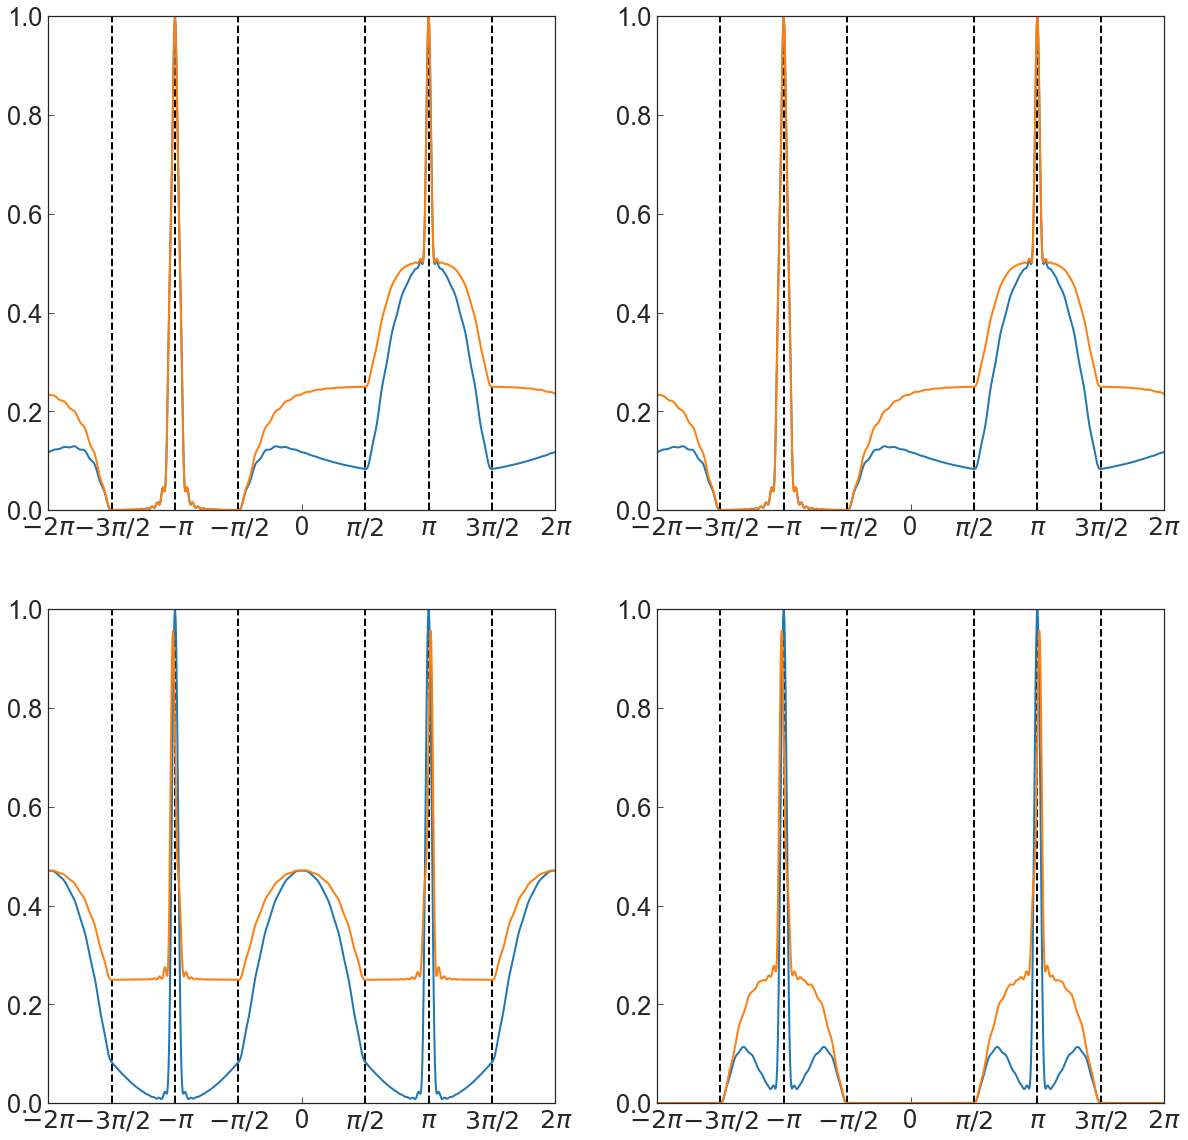

In [22]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.plot(theta_2, p1)
plt.plot(theta_2, p5)
plt.ylim(top = 1,bottom = 0)
plt.xlim((-2*np.pi,2*np.pi))
my_x_ticks = np.arange(-2*np.pi,2*np.pi+np.pi/2,np.pi/2) 
plt.xticks(my_x_ticks,('$-2\pi$','$-3\pi/2$','$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$','$3\pi/2$','$2\pi$'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")

plt.subplot(2, 2, 2)
plt.plot(theta_2, p2)
plt.plot(theta_2, p6)
plt.ylim(top = 1,bottom = 0)
plt.xlim((-2*np.pi,2*np.pi))
my_x_ticks = np.arange(-2*np.pi,2*np.pi+np.pi/2,np.pi/2) 
plt.xticks(my_x_ticks,('$-2\pi$','$-3\pi/2$','$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$','$3\pi/2$','$2\pi$'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")

plt.subplot(2, 2, 3)
plt.plot(theta_2, p3)
plt.plot(theta_2, p7)
plt.ylim(top = 1,bottom = 0)
plt.xlim((-2*np.pi,2*np.pi))
my_x_ticks = np.arange(-2*np.pi,2*np.pi+np.pi/2,np.pi/2) 
plt.xticks(my_x_ticks,('$-2\pi$','$-3\pi/2$','$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$','$3\pi/2$','$2\pi$'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")

plt.subplot(2, 2, 4)
plt.plot(theta_2, p4)
plt.plot(theta_2, p8)
plt.ylim(top = 1,bottom = 0)
plt.xlim((-2*np.pi,2*np.pi))
my_x_ticks = np.arange(-2*np.pi,2*np.pi+np.pi/2,np.pi/2) 
plt.xticks(my_x_ticks,('$-2\pi$','$-3\pi/2$','$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$','$3\pi/2$','$2\pi$'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")

plt.savefig('../fig/bound_state_3.pdf')

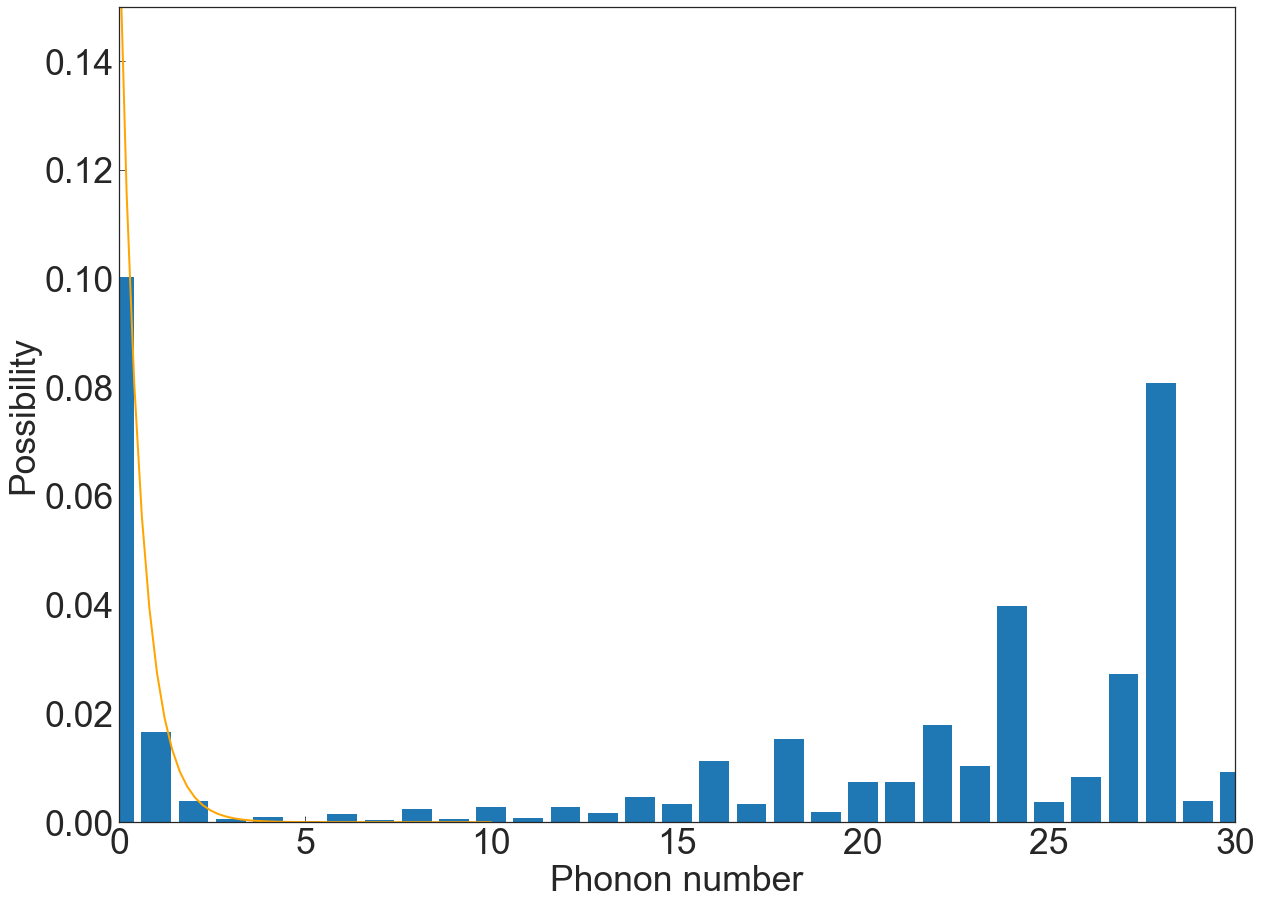

In [111]:
# state = N_step(init_state, theta_1, theta_2, N=50)
# plot result
# P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
# phonon = range(len(P))
# # plt.scatter(phonon, P, s=1000*P)
# print('total pro', sum(P))
# plt.bar(range(len(P)),P)

# plt.title('$\varepsilon$',fontsize=20)

# plt.figure(figsize=(20,20))
# for i,theta in enumerate(theta_1):
#     state = N_step(init_state, theta, theta_2, N=N)
#     P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
#     plt.subplot(6,4,i+1)
#     plt.xlabel('theta=%f'%theta)
#     plt.bar(range(5),P[:5])
## bar plot
plt.figure(figsize=(20, 15))
x = np.linspace(0,10)
def f(x):
    return pow((np.sqrt(2)-1),x)**2*(1-(np.sqrt(2)-1)**2)/5
p = np.zeros(50)
for i in range(50):
    state = n_step_2(init_state, 0, np.pi/2, N=50)
    P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    p[i] = P[i]
plt.xlim((0,30))
plt.ylim((0,0.15))
plt.bar(range(50),p)
plt.xlabel('Phonon number')
plt.ylabel('Possibility')
plt.plot(x, f(x),color='orange')
plt.savefig('../fig/bound_2.pdf')

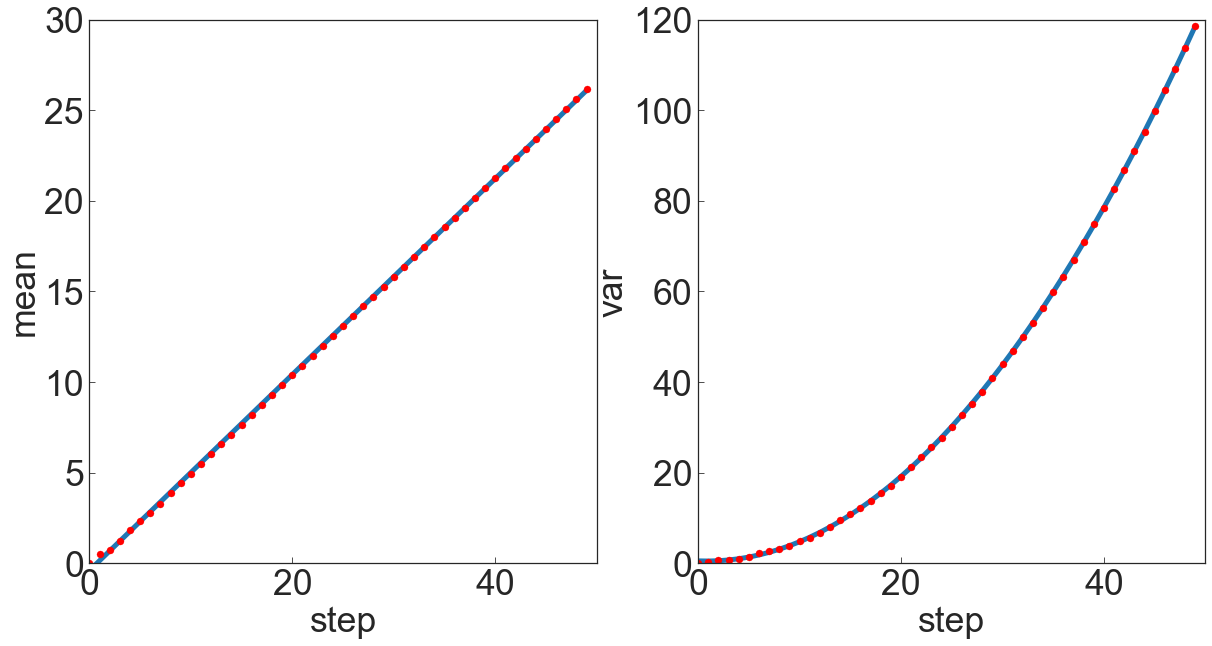

In [112]:
from scipy import optimize
 
def f_1(x, A, B):
    return A * x + B
def f_2(x, A, B, C):
    return A*x**2 +B*x + C


plt.figure(figsize=(20, 10))
mean = np.zeros(50)
var = np.zeros(50)
for i in range(50):
    state = n_step_2(init_state, 0, np.pi/2, N=i)
    P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    mean[i] = 0
    for j in range(50):
        mean[i] = mean[i] + P[j]*j
        var[i] = var[i] + P[j]*j**2
    mean[i] = mean[i]
    var[i] =  var[i] - mean[i]**2
plt.subplot(1, 2, 1)
A1, B1 = optimize.curve_fit(f_1, range(50), mean)[0]
x1 = range(50)
y1 = A1 * x1 + B1
plt.plot(x1,y1, linewidth=5, zorder=1)
plt.scatter(range(50), mean, c='r', s=50, zorder=2)
plt.xlim((0,50))
plt.ylim((0,30))
plt.xlabel('step')
plt.ylabel('mean')
plt.subplot(1, 2, 2)
a=np.polyfit(x1, var, 2)#用2次多项式拟合x，y数组
b=np.poly1d(a)#拟合完之后用这个函数来生成多项式对象
c=b(x1)#生成多项式对象之后，就是获取x在这个多项式处的值
plt.plot(x1, c, linewidth=5, zorder=1)
plt.scatter(range(50), var, c='r', s=50, zorder=2)
plt.xlim((0,50))
plt.ylim((0,120))
plt.xlabel('step')
plt.ylabel('var')
plt.savefig('../fig/bound_3.pdf')

In [ ]:
# plot thermal picture
# array=np.zeros((N,M))
# for i in range(0,N):
# 	state = N_step(init_state, theta_1, theta_2, N=i)
# 	P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
# 	array[i]=P
# plt.figure()
# plt.xlim(0,N)
# plt.xlabel('phonon')
# plt.ylabel('step')
# plt.imshow(array)
# plt.colorbar()

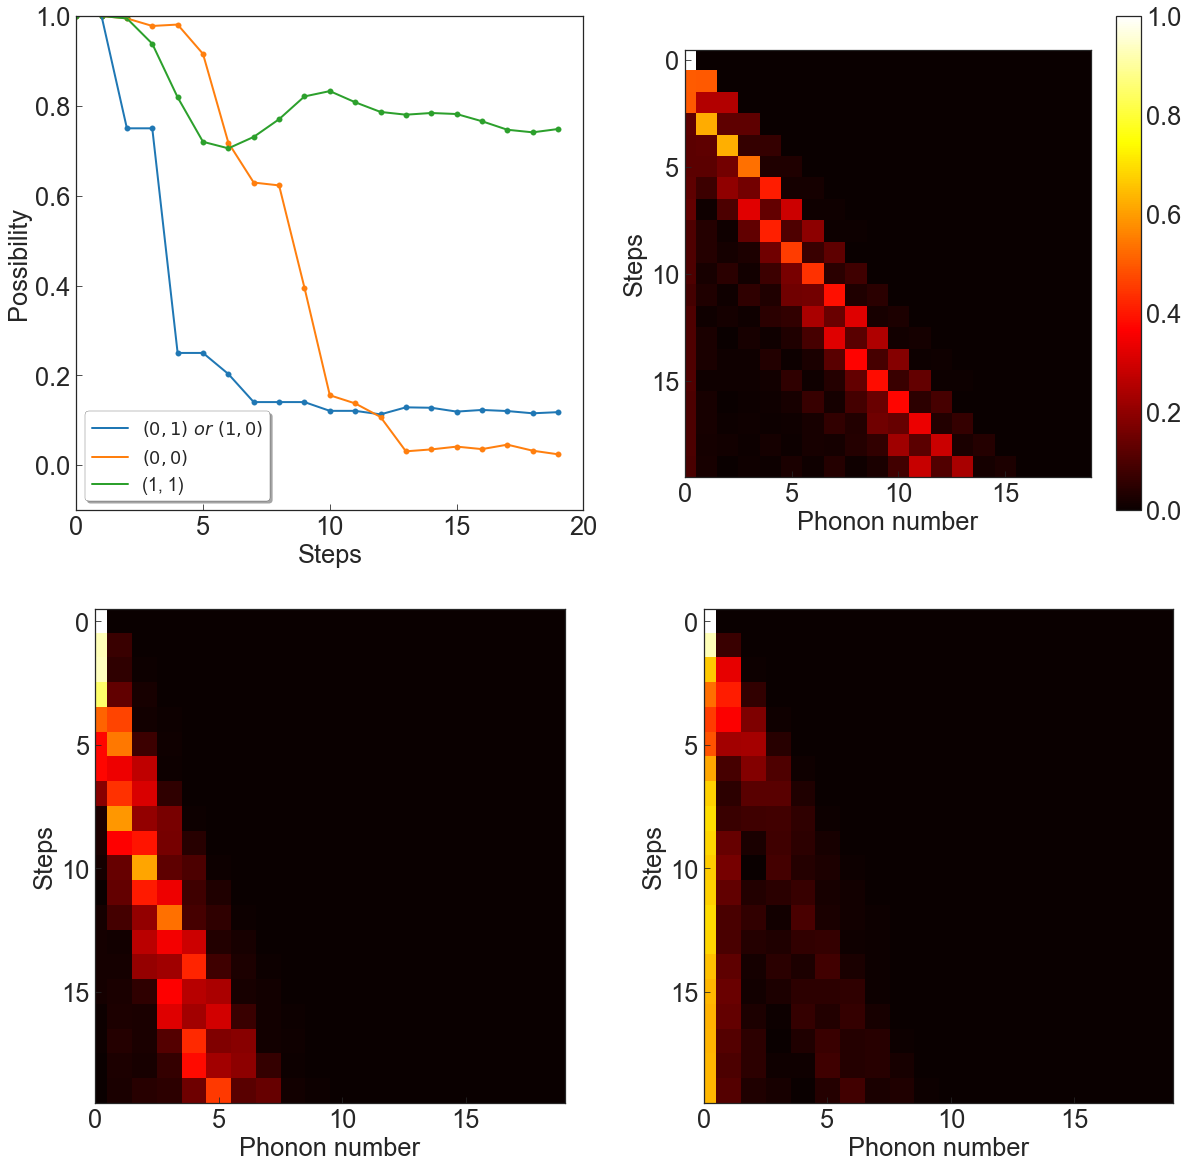

In [118]:
plt.figure(figsize=(20, 20))
M = 1000
n = 1
N = 500
loc1 = np.zeros(20)
loc2 = np.zeros(20)
loc3 = np.zeros(20)
heat1 = np.zeros((20,20))
heat2 = np.zeros((20,20))
heat3 = np.zeros((20,20))
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1
# up_state[0] = 1/np.sqrt(2)
# down_state[0] = 1/np.sqrt(2)
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i in range(20):
    state_1 = n_step_2(init_state, 0, np.pi/2, N=i)
    state_2 = n_step_2(init_state, -3*np.pi/4, np.pi/2, N=i)
    state_3 = n_step_2(init_state, 3*np.pi/4, np.pi/2, N=i)
    P_1 = abs(state_1[0])**2 + abs(state_1[1])**2 + abs(state_1[2])**2
    loc1[i] = P_1[0] + P_1[1]
    heat1[i] = P_1[0:20]
    P_2 = abs(state_2[0])**2 + abs(state_2[1])**2 + abs(state_2[2])**2
    loc2[i] = P_2[0] + P_2[1]
    heat2[i] = P_2[0:20]
    P_3 = abs(state_3[0])**2 + abs(state_3[1])**2 + abs(state_3[2])**2
    loc3[i] = P_3[0] + P_3[1]
    heat3[i] = P_3[0:20]
plt.subplot(2, 2, 1)
plt.xlim((0,20))
plt.ylim((-0.1,1))
plt.xlabel('Steps')
plt.ylabel('Possibility')
plt.scatter(range(20), loc1)
plt.plot(range(20), loc1, label='$(0, 1)\ or\ (1, 0)$')
plt.scatter(range(20), loc2)
plt.plot(range(20), loc2, label='$(0, 0)$')
plt.scatter(range(20), loc3)
plt.plot(range(20), loc3, label='(1, 1)')
plt.legend(loc='best')
my_y_ticks = [0, 5, 10, 15]
plt.subplot(2, 2, 2)
plt.xlim(0, 19)
plt.yticks(my_y_ticks,(0,5,10,15))
plt.xlabel('Phonon number')
plt.ylabel('Steps')
plt.imshow(heat1, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.subplot(2, 2, 3)
plt.xlim(0, 19)
plt.yticks(my_y_ticks,(0,5,10,15))
plt.xlabel('Phonon number')
plt.ylabel('Steps')
plt.imshow(heat2, cmap='hot', interpolation='nearest')
plt.subplot(2, 2, 4)
plt.xlim(0, 19)
plt.yticks(my_y_ticks,(0,5,10,15))
plt.xlabel('Phonon number')
plt.ylabel('Steps')
plt.imshow(heat3, cmap='hot', interpolation='nearest')
plt.savefig('../fig/bound_4.pdf')

In [241]:
alpha = np.arctan(cos(theta_1/2+theta_2/2)/(cos(theta_1/2)*cos(theta_2/2)))
yeta = (1 + sin(theta_1/2)*sin(theta_2/2))/np.sqrt((cos(theta_1/2)*cos(theta_2/2))**2+(cos((theta_1+theta_2)/2)*sin(np.pi/3))**2)

In [426]:
chi_0 = np.arcsin(np.sqrt(((1 + sin(theta_1/2)*sin(theta_2/2))**2-(cos(theta_1/2)*cos(theta_2/2))**2)/cos((theta_1+theta_2)/2)**2))
print(chi_0)

0.6093158935116536


In [427]:
k_1 = 0.6497839184553895-alpha
k_2 = -0.50733675487517-alpha
print(k_1, k_2)

-0.23769025114775477 -1.3948109244783145


In [402]:
from numpy import cos,sin
def f1(theta_1, theta_2, chi, k):
    return np.arccos(cos(k)*cos(theta_1/2)*cos(theta_2/2)-sin(theta_1/2)*sin(theta_2/2)-cos((theta_1+theta_2)/2)*sin(chi)*sin(k))
def f2(theta_1, theta_2, chi, k):
    return np.arccos(cos(k)*cos(theta_1/2)*cos(theta_2/2)-sin(theta_1/2)*sin(theta_2/2)*cos(chi))
def f3(k):
    return np.arccosh(cos(k)*cos(theta_1/2)*cos(theta_2/2)-sin(theta_1/2)*sin(theta_2/2)-cos((theta_1+theta_2)/2)*sin(chi_1)*sin(k))

In [403]:
def circle(count=1000):
    xarr=[]
    yarr=[]
    for i in range(count):
        j = float(i)/count * 2 * np.pi
        xarr.append(np.cos(j))
        yarr.append(np.sin(j))
    line, =plt.plot(xarr,yarr,color = 'blue',linewidth=2,linestyle="-")
    line.set_dashes((20,4))
def Circle(theta_1, theta_2, count=1000):
    xarr=[]
    yarr=[]
    for i in range(count):
        j = float(i)/count * (theta_2-theta_1) + theta_1
        xarr.append(np.cos(j))
        yarr.append(np.sin(j))
    line, =plt.plot(xarr,yarr,color = 'green',linewidth=10)

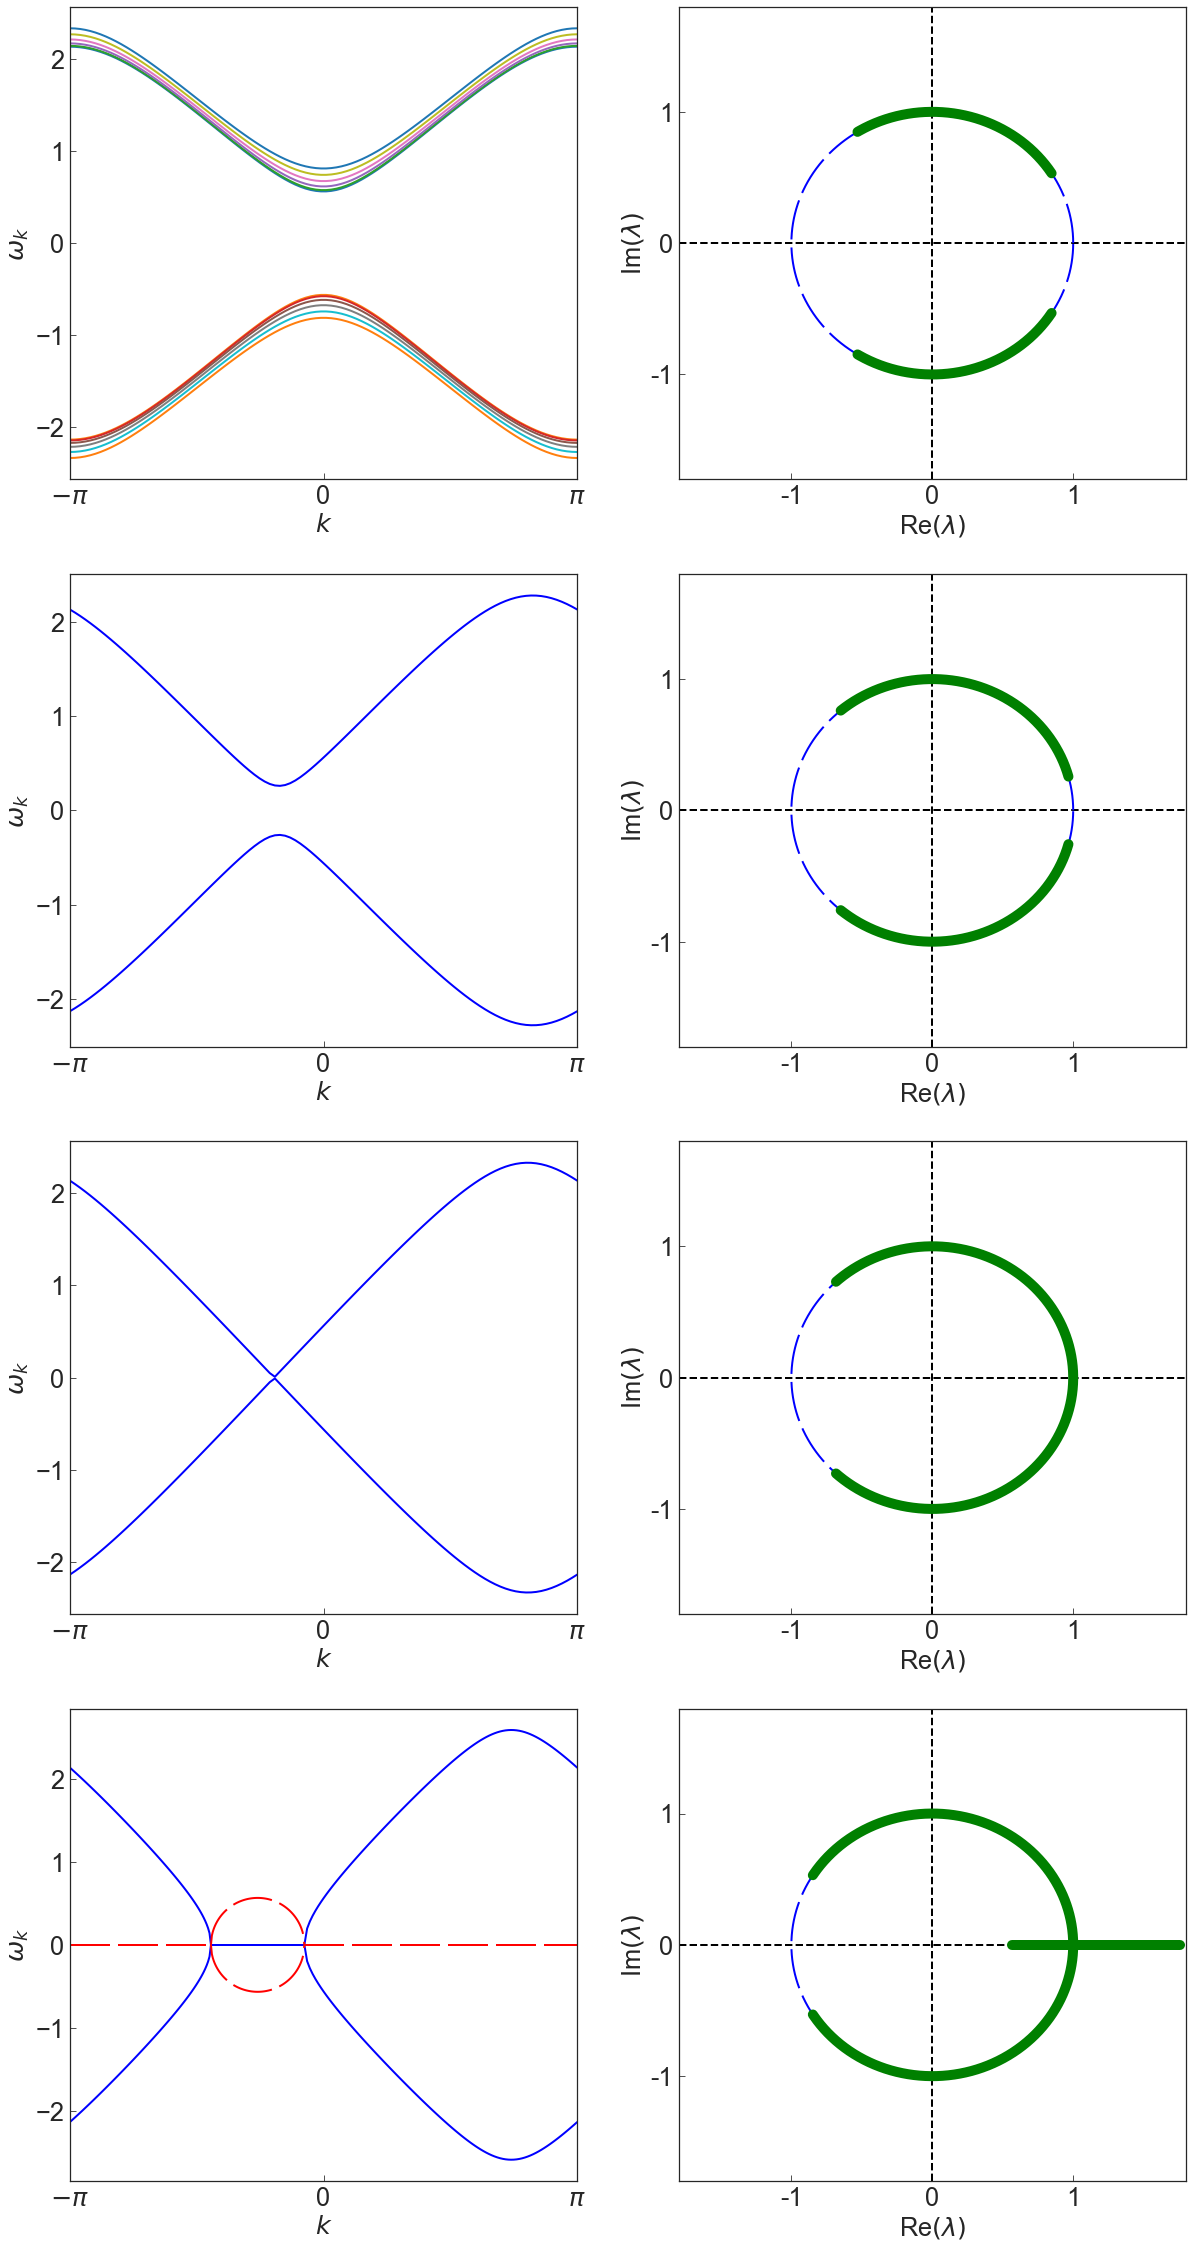

In [421]:
plt.figure(figsize=(20,40))
k = np.linspace(-np.pi, np.pi, 100)
theta_2 = np.pi/2
theta_1 = -np.pi/7
chi = np.linspace(0, np.pi/2, 6)
chi_1 = np.pi/3
Chi = np.pi/6
my_x_ticks = [0, -np.pi, np.pi]
x_ticks = [0, -1, 1]
y_ticks = [0, -1, 1]
plt.subplot(4,2,1)
plt.xlim((-np.pi, np.pi))
plt.xticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.xlabel('$k$')
plt.ylabel('$\omega_{k}$')
for c in chi:
    plt.plot(k, f2(theta_1, theta_2, c, k))
    plt.plot(k, -f2(theta_1, theta_2, c, k))
plt.subplot(4,2,2)
plt.xlim((-1.8, 1.8))
plt.ylim((-1.8, 1.8))
plt.vlines(0, -1.8, 1.8, linestyles = "dashed")
plt.hlines(0, -1.8, 1.8, linestyles = "dashed")
plt.xticks(x_ticks, (0, -1, 1))
plt.yticks(y_ticks, (0, -1, 1))
plt.xlabel('Re$(\lambda)$')
plt.ylabel('Im$(\lambda)$')
circle()
Circle(f2(theta_1, theta_2, 0, 0), f2(theta_1, theta_2, 0, np.pi))
Circle(-f2(theta_1, theta_2, 0, 0), -f2(theta_1, theta_2, 0, np.pi))
plt.subplot(4,2,3)
plt.xlim((-np.pi, np.pi))
plt.xticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.plot(k, f1(theta_1, theta_2, Chi, k), c='b')
plt.plot(k, -f1(theta_1, theta_2, Chi, k),c='b')
t_max = max(f1(theta_1, theta_2, Chi, k))
t_min = min(f1(theta_1, theta_2, Chi, k))
plt.xlabel('$k$')
plt.ylabel('$\omega_{k}$')
plt.subplot(4,2,4)
plt.xlim((-1.8, 1.8))
plt.ylim((-1.8, 1.8))
plt.vlines(0, -1.8, 1.8, linestyles = "dashed")
plt.hlines(0, -1.8, 1.8, linestyles = "dashed")
plt.xticks(x_ticks, (0, -1, 1))
plt.yticks(y_ticks, (0, -1, 1))
circle()
Circle(t_min, t_max)
Circle(-t_min, -t_max)
plt.xlabel('Re$(\lambda)$')
plt.ylabel('Im$(\lambda)$')
plt.subplot(4,2,5)
plt.xlabel('$k$')
plt.ylabel('$\omega_{k}$')
plt.xlim((-np.pi, np.pi))
plt.xticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
plt.plot(k, f1(theta_1, theta_2, chi_0, k), c='b')
plt.plot(k, -f1(theta_1, theta_2, chi_0, k), c='b')
t_max_0 = max(f1(theta_1, theta_2, chi_0, k))
t_min_0 = min(f1(theta_1, theta_2, chi_0, k))
plt.subplot(4,2,6)
plt.xlim((-1.8, 1.8))
plt.ylim((-1.8, 1.8))
plt.vlines(0, -1.8, 1.8, linestyles = "dashed")
plt.hlines(0, -1.8, 1.8, linestyles = "dashed")
plt.xticks(x_ticks, (0, -1, 1))
plt.yticks(y_ticks, (0, -1, 1))
circle()
Circle(t_min_0, t_max_0)
Circle(-t_min_0, -t_max_0)
plt.xlabel('Re$(\lambda)$')
plt.ylabel('Im$(\lambda)$')
plt.subplot(4,2,7)
plt.xlabel('$k$')
plt.ylabel('$\omega_{k}$')
plt.xlim((-np.pi, np.pi))
plt.xticks(my_x_ticks, (0, '$-\pi$', '$\pi$'))
k1 = np.linspace(-np.pi,k_2,100)
k2 = np.linspace(k_1,np.pi,100)
k3 = np.linspace(k_2,k_1,100)
plt.plot(k1, f1(theta_1, theta_2, chi_1, k1), c='b')
plt.plot(k2, f1(theta_1, theta_2, chi_1, k2), c='b')
plt.plot(k1, -f1(theta_1, theta_2, chi_1, k1), c='b')
plt.plot(k2, -f1(theta_1, theta_2, chi_1, k2), c='b')
t_max_1 = max(f1(theta_1, theta_2, chi_1, k2))
t_min_1 = 0
plt.plot(k3, np.zeros(100), c='b')
line1, = plt.plot(k3, f3(k3), c='r', linestyle="-")
line2, = plt.plot(k3, -f3(k3), c='r', linestyle="-")
line3, = plt.plot(k1, np.zeros(100), c='r', linestyle="-")
line4, = plt.plot(k2, np.zeros(100), c='r', linestyle="-")
t_max_2 = max(f3(k3))
line1.set_dashes((20,4))
line2.set_dashes((20,4))
line3.set_dashes((20,4))
line4.set_dashes((20,4))
plt.subplot(4,2,8)
plt.xlim((-1.8, 1.8))
plt.ylim((-1.8, 1.8))
plt.vlines(0, -1.8, 1.8, linestyles = "dashed")
plt.hlines(0, -1.8, 1.8, linestyles = "dashed")
plt.xticks(x_ticks, (0, -1, 1))
plt.yticks(y_ticks, (0, -1, 1))
circle()
Circle(t_min_1, t_max_1)
Circle(-t_min_1, -t_max_1)
plt.plot(np.linspace(np.exp(-t_max_2),np.exp(t_max_2),50), np.zeros(50), color = 'green', linewidth=10)
plt.xlabel('Re$(\lambda)$')
plt.ylabel('Im$(\lambda)$')
plt.savefig('../fig/symmetry.pdf')

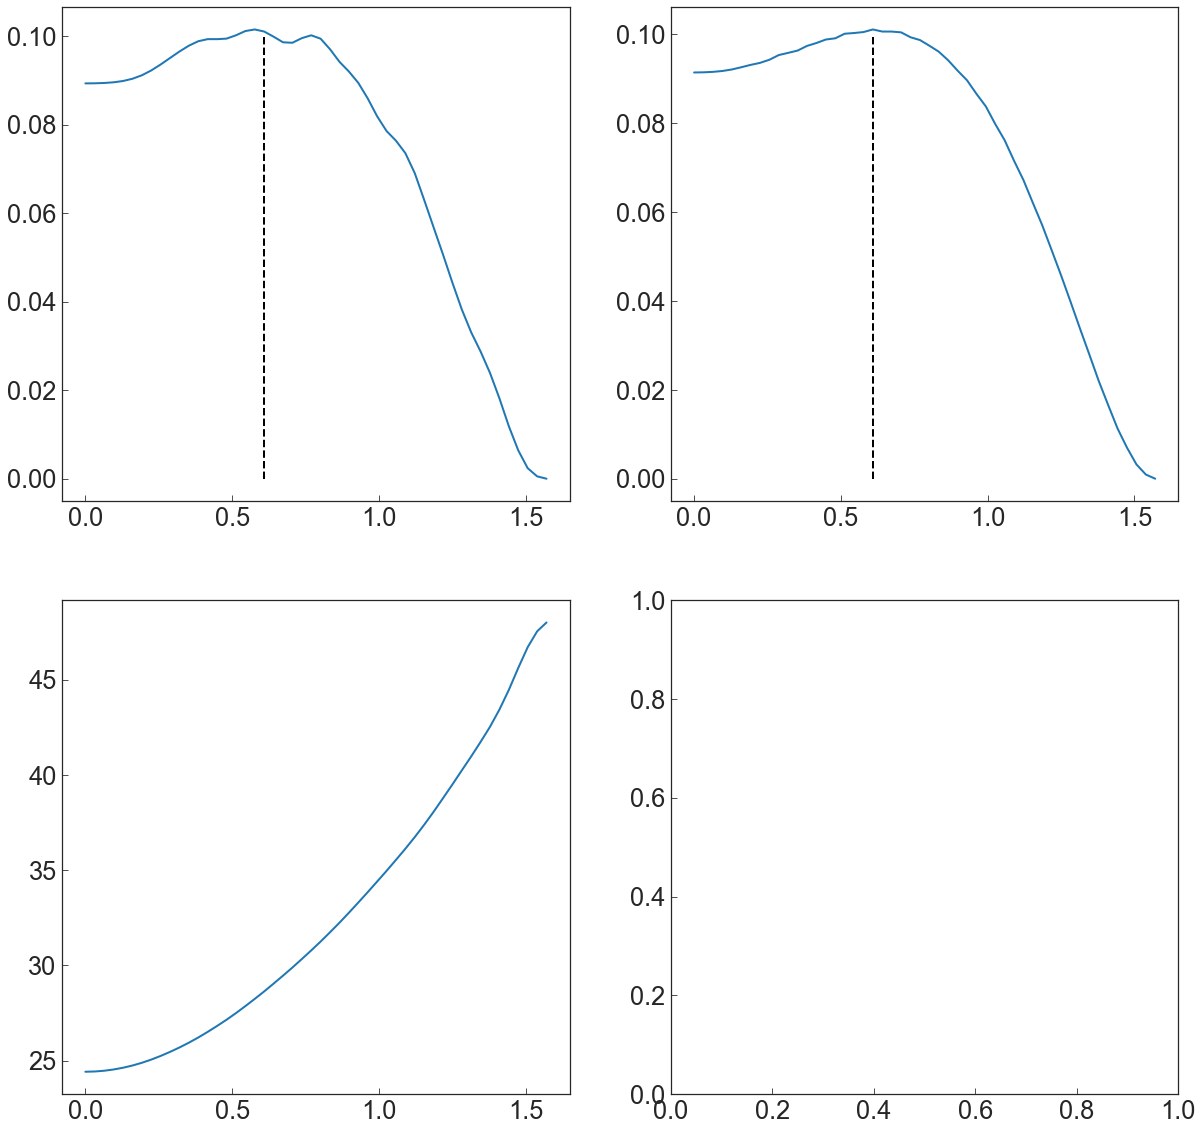

In [460]:
plt.figure(figsize=(20,20))
M = 1000
n = 1
N = 500
chi_p = np.linspace(0, np.pi/2, 50)
mean = np.zeros(50)
p9 = np.zeros(50)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[1] = 1
theta_2 = np.pi/2
theta_1 = -np.pi/7
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
plt.subplot(2,2,1)
for i,c in enumerate(chi_p):
    state9 = n_step(init_state, theta_1, theta_2, c, N=50)
    P9 = abs(state9[0])**2 + abs(state9[1])**2 + abs(state9[2])**2
    p9[i] = P9[0] + P9[1]
    mean[i] = 0
    for j in range(50):
        mean[i] = mean[i] + P9[j]*j
    mean[i] = mean[i]
plt.vlines(chi_0, 0, 0.1, linestyles = "dashed")
    
plt.plot(chi_p, p9)
plt.subplot(2,2,2)
for i,c in enumerate(chi_p):
    state9 = n_step(init_state, theta_1, theta_2, c, N=200)
    P9 = abs(state9[0])**2 + abs(state9[1])**2 + abs(state9[2])**2
    p9[i] = P9[0] + P9[1] 
plt.plot(chi_p, p9)
plt.vlines(chi_0, 0, 0.1, linestyles = "dashed")
plt.subplot(2,2,3)
plt.plot(chi_p, mean)
plt.subplot(2,2,4)
